In [1]:
! pip install wandb matplotlib tokenizers


[notice] A new release of pip is available: 23.3.1 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
#----- imports --------

import bottleneck_llm 
import tqdm
import torch
from torch import nn
import wandb
import os
import tokenizers
from matplotlib import pyplot as plt
import numpy as np
import json
from itertools import chain
from sae import TopKSparseAutoencoder
import importlib
import sys



device= 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
assert device == 'cuda', "This notebook is not optimized for CPU"

config = {
    "learning_rate": 2e-3,
    "sae_learning_rate": 5e-5,
    "model_embedding_layer": 6,
    "eval_interval": 500,
    "max_iters": 60000, 
    "H": 32, # hidden dimension size
    "B": 128,
    "T": 256,
    "C": 256,
    "feedforward_factor": 3,
    "n_heads": 8,
    "n_layers": 12,
    "sae_size": 2**14,
    "sae_location": 6,
    "sae_topk": 20,
    "sae_r2_lambda": 2,
    "sae_mse_lambda": 0,

    "tokenizer_vocab_size": 2**13,
    "git_hash": os.popen("git rev-parse HEAD").read().strip()
}

# initial
for k,v in config.items():
    locals ()[k] = v


torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
!wandb disabled

wandb.init(
   project = "static-sae",
   config = config,
)

W&B disabled.


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


In [3]:

# stories_data = []
# data_dir = './data'
# for filename in os.listdir(data_dir):
#     file_path = os.path.join(data_dir, filename)
#     if filename.endswith('.json'):
#         with open(file_path, 'r', encoding='utf-8') as f:
#             data = json.load(f)
#             stories_data.extend(data)






In [4]:
# # load the tinystories tokenizer
# tokenizer = tokenizers.ByteLevelBPETokenizer(
#     "./tiny-stories-bpe-vocab.json", 
#     "./tiny-stories-bpe-merges.txt"
# )



# def encode(text):
#     return torch.tensor(tokenizer.encode(text).ids, dtype=torch.int64)
# def decode(encoded_text):
#     return tokenizer.decode(encoded_text.tolist())

# from tqdm import tqdm

# encoded_stories = [encode(story['story']) for story in tqdm(stories_data, desc="Encoding stories")]



In [5]:
# # save the encoded stories to a file
# torch.save(encoded_stories, 'encoded-stories.pt')

In [6]:

# with open('tinystories-train.txt', 'r', encoding='utf-8') as f:
#     text = f.read()
#     print("length of dataset in characters: ", len(text))
#     print("length of dataset in lines: ", len(text.split('\n'))) 
#     print(text[:1000])
    # print("length of dataset in characters: ", len(text[:10000]))
    # print("length of dataset in tokens: ", len(encode(text[:10000])))
    # chars_per_token = len(text[:10000]) / len(encode(text[:10000]))
    # print("characters per token: ", chars_per_token) # 4.098360655737705
chars_per_token = 4.098360655737705

In [7]:
# paths = ['tinystories-train.txt']
# tokenizer = tokenizers.ByteLevelBPETokenizer()

# tokenizer.train(files=paths, vocab_size=tokenizer_vocab_size, min_frequency=2)

# tokenizer.save_model('.', 'tiny-stories-bpe')



# enc = tokenizer.encode("She sells sea shells by the sea shore!")
# tokenizer.decode(enc.ids)



In [8]:
tokenizer = tokenizers.ByteLevelBPETokenizer(
    "./tiny-stories-bpe-vocab.json", 
    "./tiny-stories-bpe-merges.txt"
)


In [9]:

def encode(text):
    return tokenizer.encode(text).ids
def decode(encoded_text):
    return tokenizer.decode(encoded_text)

from tqdm import tqdm

def batch_encode(text, batch_size):
    tokens = []
    for i in tqdm(range(0, len(text), batch_size)):
        tokens.extend(encode(text[i:i+batch_size]))
    return tokens


hello_encoded = encode("hello")
print(hello_encoded)
print(decode(hello_encoded))
vocab_size = tokenizer.get_vocab_size()
print("vocab size: ", vocab_size)

[6099]
hello
vocab size:  8192


In [10]:
# encoded_text = batch_encode(text, 200000)
# # data = torch.tensor(encode(text), dtype=torch.int64)
# data = torch.tensor(encoded_text, dtype=torch.int64, device='cuda')
# print(data.dtype)
# print(data.size())
# print(data.device)
# torch.save(data, 'tiny-stories-train.pt')
# encoded_text = None


In [11]:
# load data from tiny-stories-train.pt
data = torch.load('tiny-stories-train.pt', map_location='cuda')


In [12]:
len(data)

468163695

In [13]:

train_data = data[:n]
val_data = data[n:]

In [14]:
train_data.size()

torch.Size([421347325])

In [15]:
train_data[:T+1]

tensor([ 427,  357,   11,  258,  405,  452,  507,  365,  600,  258, 3729,  316,
         308,  763,   13,  312,  708,  303,  281, 2965,  265,  360,  342,  303,
         792,  303,  281, 2120,   13,  365,  450,  265,  953,  262, 3729,  342,
         308,  367,   11,  350,  338,  466, 5179,  258, 2227,  345,  308, 2498,
          13,  198,  343,  475,  265,  308,  367,  264,  326,   11,  328,  775,
          11,  335,  600,  745, 3729,   13, 1283,  346,  953,  303,  342,  525,
         264, 5179,  656, 2498,  484,  870,  367,  505,  264,  326,   11,  328,
         835,   11,  365,   11,  368,  478,  953,  262, 3729,  264, 1307,  633,
        2498,  421,  198, 4611,   11,  364, 1658,  262, 3729,  264, 7866,  262,
        2227,  345,  365,  374, 2498,   13,  415,  281,  393, 2965,  369,  454,
         792,  364,  435, 2500,  264, 1763,  761,  576,   13, 1454,  364, 1444,
          11,  365,  863,  308,  367,  369, 2500,  262, 3729,  264, 5132,  308,
        2498,   13,  320,  900,  520,  4

In [16]:
decode(train_data[:T+1].cpu().numpy())

'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them because they were sharing and helping each other. After they finished, Lily thanked her mom for sharing the needle and fixing her shirt. They both felt happy because they had shared and worked together.\n<|endoftext|>\nOnce upon a time, there was a little car named Beep. Beep loved to go fast and play in the sun. Beep was a healthy car because he always had good fuel. Good fuel made Beep happy and strong.\nOne day, Beep was driving in the park when he saw a big tree. The tree had many leaves th

In [17]:
x = train_data[:T]
y = train_data[1:T+1]
for t in range(T):
    context = x[:t+1]
    target = y[t]
    # print("when we see the text", context, "we predict the next character is", target)

In [18]:
torch.manual_seed(1337)

def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, data.size(0) - T, (B,)) # 4 random locations we can sample from
    x = torch.stack([data[i:i+T] for i in ix]) # random sequences
    y = torch.stack([data[i+1:i+T+1] for i in ix]) # next character for each random sequence

    return x, y



xb, yb = get_batch('train')

for b in range(B):
    for t in range(T): # for each of the characters in the sample
        context = xb[b, :t+1]
        target = yb[b, t]


In [36]:
torch.linspace(0, T*B, B)

tensor([    0.0000,   258.0157,   516.0315,   774.0472,  1032.0630,  1290.0787,
         1548.0945,  1806.1102,  2064.1260,  2322.1416,  2580.1575,  2838.1733,
         3096.1890,  3354.2046,  3612.2205,  3870.2363,  4128.2520,  4386.2676,
         4644.2832,  4902.2993,  5160.3149,  5418.3306,  5676.3467,  5934.3623,
         6192.3779,  6450.3936,  6708.4092,  6966.4253,  7224.4409,  7482.4565,
         7740.4727,  7998.4883,  8256.5039,  8514.5195,  8772.5352,  9030.5508,
         9288.5664,  9546.5830,  9804.5986, 10062.6143, 10320.6299, 10578.6455,
        10836.6611, 11094.6768, 11352.6934, 11610.7090, 11868.7246, 12126.7402,
        12384.7559, 12642.7715, 12900.7871, 13158.8027, 13416.8184, 13674.8350,
        13932.8506, 14190.8662, 14448.8818, 14706.8975, 14964.9131, 15222.9287,
        15480.9453, 15738.9609, 15996.9766, 16254.9922, 16513.0078, 16771.0234,
        17029.0391, 17287.0547, 17545.0703, 17803.0859, 18061.1016, 18319.1172,
        18577.1348, 18835.1504, 19093.16

In [19]:

import torch
import torch.nn as nn
from torch.nn import functional as F
# torch.manual_seed(1337)


class Head(nn.Module):
    '''One Head of self-attention'''
    def __init__(self, H):
        super().__init__()
        self.query = nn.Linear(C, H, bias=False)
        self.key = nn.Linear(C, H, bias=False)
        self.value = nn.Linear(C, H, bias=False)
        # self.output = nn.Linear(H, C, bias=False) # output matrix
        self.register_buffer('tril', torch.tril(torch.ones(T, T)))

    def forward(self, x):
        # Query and Key matrices for the attention mechanism
        # x: 8 tokens
        # Q: 16 tall (arbitrary), 32 long channels
        # K: 16 tall (arbitrary), 32 long channels

        query_vectors = self.query(x)
        key_vectors = self.key(x)


        # Attention masking(so we can't look into the past):

        tril = self.tril
        wei = torch.zeros(T, T) 
        wei = wei.masked_fill(tril == 0, float('-inf')) # set the upper triangular to -inf
        # xbow = wei @ x # apply the mask to the input, bag of words because simple avg.

        # multiply the two to get the attention weights
        attention_pattern = query_vectors @ key_vectors.transpose(-2, -1) # T, T
        attention_pattern = attention_pattern / (H ** 0.5) # scale the attention pattern for numerical stability
        attention_weights = F.softmax(attention_pattern + wei, dim=-1) # T, T (the row dimension is the query)

        value_vectors = self.value(x) # the direction we should go in the embedding space for each token (ie more blue) T, H

        # apply the attention weights to the value vectors
        context = attention_weights @ value_vectors # T, H

        # project back into original space from value space
        # return self.output(context)
        return context

x = torch.randn(B,T,C)
head = Head(H)
# head(x)


In [20]:
class MultiHeadAttention(nn.Module):
    '''Multiple heads of self-attention'''
    def __init__(self, H, C, n_heads): # H is head embedding space size, n_heads is number of heads
        super().__init__()
        self.heads = nn.ModuleList([Head(H) for _ in range(n_heads)])
        self.combine_heads = nn.Linear(H*n_heads, C)


    def forward(self,x):
        x = torch.cat([head(x) for head in self.heads], dim=-1)
        x = self.combine_heads(x)  # T, C
        return x

In [21]:
head = MultiHeadAttention(H, C, n_heads)
head.heads[0].forward(x).shape


torch.Size([128, 256, 32])

In [22]:
class FeedForward(nn.Module):
    '''Feed-forward neural network'''
    def __init__(self, C):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(C, C * feedforward_factor),
            nn.ReLU(),
            nn.Linear(C * feedforward_factor, C),
        )

    def forward(self, x):
        return self.net(x)

In [23]:
class LayerNorm(nn.Module):
    '''Layer normalization'''
    def __init__(self, C, use_affine=True):
        super().__init__()
        self.gamma = nn.Parameter(torch.ones(C)) if use_affine else None
        self.beta = nn.Parameter(torch.zeros(C)) if use_affine else None

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        if self.gamma is not None and self.beta is not None:
            return self.gamma * (x - mean) / (std + 1e-6) + self.beta
        else:
            return (x - mean) / (std + 1e-6)

In [24]:
class Block(nn.Module):
    '''Transformer block'''
    def __init__(self, H, C, n_heads):
        super().__init__()
        self.attention = MultiHeadAttention(H, C, n_heads)
        self.ff = FeedForward(C)
        self.norm1 = LayerNorm(C, use_affine=True)
        self.norm2 = LayerNorm(C, use_affine=True)

    def forward(self, x):
        x = x + self.attention(self.norm1(x))
        x = x + self.ff(self.norm2(x))
        return x

# SAE Def


In [25]:
joint_sae = TopKSparseAutoencoder(C, sae_size, sae_topk)

# parameters_to_optimize = list(model.parameters())

# for name, param in static_sae.named_parameters():
#     if name != 'bias':
#         param.requires_grad=False
#         print(f"set {name}.requires_grad to false")
#     else:
#         print("adding bias to list")
#         parameters_to_optimize.append(param)

# for param in model.parameters():
#     param.requires_grad = False
joint_sae.forward(torch.randn(C)).keys()

dict_keys(['encoded', 'decoded', 'topk_idxs', 'topk_values', 'mse'])

# LLM Def

In [30]:

class GPT(nn.Module):

    def __init__(self, n_layers, bottleneck_model):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, C) 
        self.position_embedding_table = nn.Embedding(T, C)
        self.lm_head = nn.Linear(C, vocab_size)
        self.layers = nn.ModuleList([Block(H, C, n_heads) for _ in range(n_layers)])
        self.bottleneck_model = bottleneck_model
    
    def forward(self,
                idx,
                targets=None,
                bottleneck_early_stop=False
                ):
        bottleneck_model = self.bottleneck_model
        B, T = idx.shape
        token_emb = self.token_embedding_table(idx) # batch_dim, sequence_dim, embedding_dim
        pos_emb = self.position_embedding_table(torch.arange(T))
        x = token_emb + pos_emb # token identities and positions contained

        results = {}

        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i == sae_location:
                if bottleneck_model:
                    bm_results = bottleneck_model(x)
                    x = bm_results['decoded']
                    results['bm_results'] = bm_results
                    if bottleneck_early_stop:
                        return results
        
        logits = self.lm_head(x) # batch_dim, sequence_dim, vocab_size

        batch_dim, sequence_dim, embedding_dim = logits.size()

        results['logits'] = logits

        if targets is not None:
            logits_loss_view = logits.view(-1, vocab_size) 
            targets_loss_view = targets.view(-1)
            loss = F.cross_entropy(logits_loss_view, targets_loss_view)
            results['loss'] = loss

        return results
        

    def generate(self, idx, max_new_tokens, temperature=0.5):
        for _ in range(max_new_tokens):
            logits, loss = self(idx[:,-T:])
            # get the predictions of the last token
            last_token_logits = logits[:, -1, :] # all batches, last token, all probabilities
            # apply temperature
            last_token_logits = last_token_logits / temperature
            # softmax to get probabilities
            probabilities = F.softmax(last_token_logits, dim=-1)
            # sample from the probabilities
            next_token = torch.multinomial(probabilities, num_samples=1)
            # add the new token to the idx tensor
            idx = torch.cat((idx, next_token), dim=1)
        return idx
    def prompt_model(self, prompt, max_new_tokens, bottleneck_model=None, temperature=0.5):
        autoregressive_seq = encode(prompt)
        for _ in range(max_new_tokens):
            prediction_index = len(autoregressive_seq)-1

            model_input = torch.tensor(autoregressive_seq)
            
            while model_input.shape[0] < T:
                pad_token = torch.tensor(encode("\n"))
                model_input = torch.cat((model_input, pad_token), dim=0)

            model_input
            model_input = model_input.unsqueeze(0)

            model_output = model(model_input, bottleneck_model = bottleneck_model)
            logits = model_output['logits']
            prediction_token = logits[:, prediction_index, :] / temperature
            probabilities = F.softmax(prediction_token, dim=-1)
            next_token = torch.multinomial(probabilities, num_samples=1)
            next_token = next_token.item()

            autoregressive_seq.append(next_token)
        # get the autoregressive sequence
        return decode(autoregressive_seq)
    def get_embedding(self, prompt, override_model_embedding_layer=None):
        if override_model_embedding_layer is None:
            selected_model_embedding_layer = model_embedding_layer
        else:
            selected_model_embedding_layer = override_model_embedding_layer
        sequence = encode(prompt)
        model_input = torch.tensor(sequence)
        sequence_index = len(sequence) - 1
        while model_input.shape[0] < T:
            pad_token = torch.tensor(encode("\n"))
            model_input = torch.cat((model_input, pad_token), dim=0)
        model_input = model_input.unsqueeze(0)
        embedding = self.forward(model_input, return_residuals=selected_model_embedding_layer)
        # remove the batch dimension
        embedding = embedding.squeeze(0)[sequence_index]
        return embedding

#if 'my_module' in sys.modules:
#    del sys.modules['my_module']

# 2. Reload the module
importlib.reload(bottleneck_llm)


model = bottleneck_llm.BottleNeckGPT(
    B=B,
    T=T,
    C=C,
    n_heads=n_heads,
    H=H,
    n_layers = n_layers,
    bottleneck_model=joint_sae,
    bottleneck_location=sae_location,
    vocab_size=vocab_size,
    )

test_idx = torch.zeros(1, T).long()
results = model.forward(idx=test_idx, bottleneck_early_stop=False)
print(results.keys())
# decode(model.generate(idx=test_idx, max_new_tokens=100)[0].tolist())
model.forward(test_idx, targets=test_idx)

dict_keys(['bm_results', 'logits'])


{'bm_results': {'encoded': tensor([[[0., -0., -0.,  ..., -0., -0., 0.],
           [0., 0., -0.,  ..., 0., -0., -0.],
           [-0., -0., -0.,  ..., 0., -0., 0.],
           ...,
           [-0., -0., 0.,  ..., 0., -0., -0.],
           [0., 0., -0.,  ..., 0., -0., -0.],
           [-0., 0., -0.,  ..., 0., -0., -0.]]], device='cuda:0',
         grad_fn=<MulBackward0>),
  'decoded': tensor([[[-0.3604, -1.1380,  1.8273,  ...,  1.1712, -1.7211,  2.0981],
           [-1.2039, -0.4544, -0.3877,  ...,  1.9344, -0.2822,  1.0722],
           [-1.2365, -1.8186,  0.9044,  ..., -0.0207,  0.2065,  0.6823],
           ...,
           [-0.1802, -0.8539,  1.8924,  ...,  3.3592, -1.1636,  0.8651],
           [-2.1220, -0.1052,  0.2190,  ...,  2.7543,  0.1774,  0.9505],
           [-1.5532, -0.3136, -0.2871,  ...,  3.7815,  0.4556,  1.4306]]],
         device='cuda:0', grad_fn=<AddBackward0>),
  'topk_idxs': tensor([[[ 4681,  1227, 12591,  ..., 14497, 12137,  7445],
           [ 7091, 14556, 14133,  

In [33]:
!rm 'joint_sae_models/bottleneck_model.pt'

In [84]:
def foo(hay, bar):
    return hay + bar

foo(
    hay='hay',
    bar='bar
)

'haybar'

In [27]:
model

GPT(
  (token_embedding_table): Embedding(8192, 256)
  (position_embedding_table): Embedding(256, 256)
  (lm_head): Linear(in_features=256, out_features=8192, bias=True)
  (layers): ModuleList(
    (0-11): 12 x Block(
      (attention): MultiHeadAttention(
        (heads): ModuleList(
          (0-7): 8 x Head(
            (query): Linear(in_features=256, out_features=32, bias=False)
            (key): Linear(in_features=256, out_features=32, bias=False)
            (value): Linear(in_features=256, out_features=32, bias=False)
          )
        )
        (combine_heads): Linear(in_features=256, out_features=256, bias=True)
      )
      (ff): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=256, out_features=768, bias=True)
          (1): ReLU()
          (2): Linear(in_features=768, out_features=256, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
    )
  )
  (bottleneck_model): TopKSparseAutoencoder(
    (encode): Linear(i

In [28]:
# get the number of parameters in the model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("number of parameters in the model: ", count_parameters(model))

number of parameters in the model:  20548864


In [29]:
eval_iters = 10
eval_interval = 300
@torch.no_grad()
def estimate_loss(is_last=False):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        real_iters = eval_iters
        if is_last and split == 'val':  # increase last eval to mitigate noise
            real_iters *= 10 
        losses = torch.zeros(real_iters)
        for k in range(real_iters):
            X, Y = get_batch(split)
            model_out = model(X, Y)
            loss = model_out['loss']
            losses[k] = loss.item()
        out[split] = losses.mean()# / chars_per_token
    model.train()
    return out
    

In [30]:
train_logs = []

# Train Loop


In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    # "learning_rate": 2e-3,
    # "sae_learning_rate": 5e-5,
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
logging_interval = 300
# optimizer = torch.optim.SGD(model.parameters(), lr=0.000001, momentum=0.9)
# "learning_rate": 2e-3,

import tqdm
num_params = sum([p.numel() for p in model.parameters()])
print(f'{num_params=}')

train_logs = []
for steps in tqdm.tqdm(range(max_iters)):
    optimizer.zero_grad(set_to_none=True)
    xb, yb = get_batch('train')
    model_out = model.forward(xb,
              targets=yb    )
    loss = model_out['loss']
    model_out['llm_loss'] = loss
    
    wandb.log({n: s.item() for n, s in model_out.items() if s.numel() == 1 })
    loss.backward()
    optimizer.step()


losses = estimate_loss(is_last=True)
# wandb.log({"train": losses['train'].item(), "val": losses['val'].item()})
# wandb.finish()


num_params=20548864


  0%|          | 0/60000 [00:00<?, ?it/s]

  9%|▉         | 5291/60000 [18:45<3:14:01,  4.70it/s]


KeyboardInterrupt: 

In [34]:
model_name = 'joint_composed.pt'
os.makedirs('models', exist_ok=True)
os.makedirs('sae_models', exist_ok=True)
os.makedirs('joint_sae_models', exist_ok=True)

In [35]:
model_path = f"joint_sae_models/{model_name}"

# Save the main model
torch.save(model.state_dict(), model_path)
print(f"Main model saved to {model_path}")


Main model saved to joint_sae_models/joint_composed.pt


In [ ]:
# save model
# torch.save(model.state_dict(), 'tiny-stories-model-kurtosis-regularize-0.44-loss.pt')



In [36]:
# load the model
# model.load_state_dict(torch.load('models/tiny-stories-model-normal-0.44-loss.pt'))
model.load_state_dict(torch.load(model_path))



<All keys matched successfully>

In [ ]:
print(model.prompt_model("<|endoftext|>\nOnce upon a time, there was a little boy", 200, 0.4))


ValueError: not enough values to unpack (expected 3, got 2)

In [37]:
estimate_loss()

{'train': tensor(1.8462, device='cuda:0'),
 'val': tensor(1.8526, device='cuda:0')}

# Interpretability Code

## Feature Accumulation

# Kurtosis debugging

In [ ]:
story1='''Once upon a time, in a big forest, there lived a rhinoceros named Roxy. Roxy loved to climb. She climbed trees, rocks, and hills. One day, Roxy found an icy hill. She had never seen anything like it before. It was shiny and cold, and she wanted to climb it.
Roxy tried to climb the icy hill, but it was very slippery. She tried again and again, but she kept falling down. Roxy was sad. She wanted to climb the icy hill so much. Then, she saw a little bird named Billy. Billy saw that Roxy was sad and asked, "Why are you sad, Roxy?"
Roxy told Billy about the icy hill and how she couldn't climb it'''

# assume BxTxC
def excess_kurtosis(emb):
    mean = torch.mean(emb, dim=-1, keepdim=True) # BxTx1
    std = torch.std(emb, dim=-1, keepdim=True) # BxTx1

    centralized = emb - mean #BxTxC
    fourth_moment = torch.mean(centralized**4, dim=-1, keepdim=True) # BxTx1
    kurtosis = torch.squeeze(fourth_moment / std**4, dim=-1) # BxT
    return kurtosis - 3



emb1 = model.get_embedding("Tim and Lily saw a big dog", override_model_embedding_layer=6)
emb2 = model.get_embedding("Lilly and Tim noticed a cat", override_model_embedding_layer=6)


import matplotlib.pyplot as plt
import numpy as np



# Plot emb1 and emb2 in the same plot
# plt.figure(figsize=(10, 5))
# plt.plot(np.square(emb1.cpu().detach().numpy()), label='emb1', color='blue')
# plt.plot(np.square(emb2.cpu().detach().numpy()), label='emb2', color='red')
# plt.xlabel('Index')
# plt.ylabel('Value')
# plt.title('emb1 and emb2 Plot')
# plt.legend()
# plt.show()



# get the index of the highest value
# Assuming emb1 and emb2 are tensors
highest_value_index_emb1 = torch.argmax(emb1).item()
highest_value_index_emb2 = torch.argmax(emb2).item()

lowest_value_index_emb1 = torch.argmin(emb1).item()
lowest_value_index_emb2 = torch.argmin(emb2).item()

print(f"Index of the highest value in emb1: {highest_value_index_emb1}")
print(f"Index of the highest value in emb2: {highest_value_index_emb2}")
print(f"Index of the lowest value in emb1: {lowest_value_index_emb1}")
print(f"Index of the lowest value in emb2: {lowest_value_index_emb2}")

print(f"emb1 excess kurtosis: {excess_kurtosis(emb1)}")
print(f"emb2 excess kurtosis: {excess_kurtosis(emb2)}")

# dot product between emb1 and emb2
emb1_l2 = F.normalize(emb1, p=2, dim=-1)
emb2_l2 = F.normalize(emb2, p=2, dim=-1)
print(f"Dot product between emb1 and emb2: {torch.dot(emb1_l2, emb2_l2)}")



Index of the highest value in emb1: 239
Index of the highest value in emb2: 146
Index of the lowest value in emb1: 203
Index of the lowest value in emb2: 81
emb1 excess kurtosis: -0.31801652908325195
emb2 excess kurtosis: -0.1101229190826416
Dot product between emb1 and emb2: 0.8099309206008911


emb1 excess kurtosis: 157.1050262451172
emb2 excess kurtosis: 156.85986328125
when we load the model trained from this notebook, it has excess kurtosis of 157.1050262451172

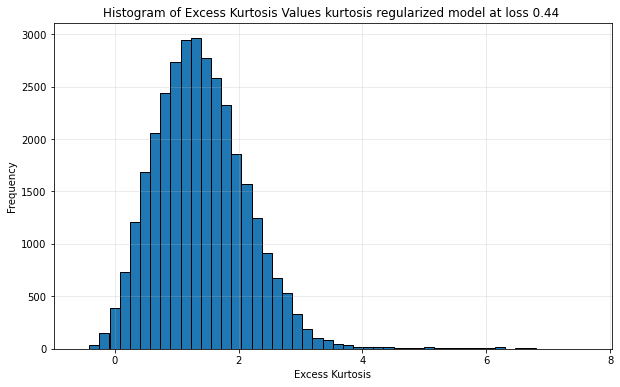

tensor(1.3952, device='cuda:0', grad_fn=<MeanBackward0>)


In [ ]:
xb, yb = get_batch('val')
emb = model.forward(xb, return_residuals=model_embedding_layer)

# emb.shape
kurtosis_values = excess_kurtosis(emb).view(-1)
import matplotlib.pyplot as plt

# Convert kurtosis values to CPU and numpy for plotting
kurtosis_np = kurtosis_values.cpu().detach().numpy()

plt.figure(figsize=(10, 6))
plt.hist(kurtosis_np, bins=50, edgecolor='black')
plt.xlabel('Excess Kurtosis')
plt.ylabel('Frequency')
plt.title('Histogram of Excess Kurtosis Values kurtosis regularized model at loss 0.44 ')
plt.grid(True, alpha=0.3)
plt.show()


print(kurtosis_values.mean())